In [1]:
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook')
sns.set(style='darkgrid')
from pipe import Pipe
import easier as ezr

%matplotlib inline
import pylab as pl
import holoviews as hv
# hv.extension('bokeh')

pd.set_option("display.max_columns",101)

/Users/rob/anaconda3/envs/daq/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
# the directory holding data files
data_dir = './20180318/'

# the file name for the test log (it should live in the data directory)
test_log_file_base_name = 'test_log_20180318.csv'

# this is the maximum number of identical samples to take 
max_samples = 3
channel_mapper= dict(
    a='sig_gen',
    b='res_volt',
    c='rec_volt',
    d='sec_volt'
)

# compute the full path of the test log file
test_log_file = os.path.join(data_dir, test_log_file_base_name)

In [3]:
def find_files(data_dir):
    """
    Find all data files under a specified directory
    """
    # the regex pattern for identifying a data file
    rex_file = re.compile(r'.*/?\d+\-\d+(_\d+)?\.csv')
    
    # initialize empty list of data files
    data_files = []
    
    # recursively search data directory
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            # only consider data files
            if rex_file.match(file):
                
                # compute the full path to the datafile
                file_name = os.path.join(root, file)
                
                # the file_tag is what is put into the log file
                file_tag = re.sub(r'(_\d+)?.csv', '', file)
                
                # add the data file
                data_files.append((file_tag, file_name))
    
    # create and return the output dataframe
    df_files = pd.DataFrame(data_files, columns=['file_tag', 'file_name'])
    return df_files

In [108]:
def make_log_frame(test_log_file, data_dir, max_samples):
    # read in the test log
    df_log = pd.read_csv(test_log_file).drop(['test_no'], axis=1)
    
    # standardize column names
    df_log = df_log.rename(
        columns=dict(primary_position='pos', file_name='file_tag', fatigue_life='life'))
    
    # sometimes the file will have blank fields.  These are garbage
    df_log.dropna(inplace=True)
    
    # get a frame of all files in the data directory
    df_files = find_files(data_dir)
    
    # Use the file_tag to link each data file with its corresponding log-file entry
    df_out = pd.merge(df_log, df_files, on=['file_tag'], how='right')
    
    
    def compute_sample_num(batch):
        """
        For each condition measured, this function computes the sample numbe
        """
        batch.insert(3, 'sample_num', np.array(range(len(batch))) + 1)
        return batch  
    
    # These fields identify measurement conditions (that can be sample multiple times)
    grouping_fields = ['sample', 'frequency', 'bends', 'pos']
    
    # This will order by filename within batches, although it's no clear that's needed
    sorting_fields = grouping_fields + ['file_name']
    df_out = df_out.sort_values(by=sorting_fields)
    
    # Actually run the groupby to assign sample number
    df_out = df_out.groupby(by=grouping_fields).apply(compute_sample_num)
    
    # Select the final output fields you want in the log frame
    df_out = df_out[grouping_fields + ['sample_num', 'file_name']]
    
    # Don't include more than max_samples for each measurement condition
    df_out = df_out[df_out.sample_num <= max_samples].reset_index(drop=True)
    
    return df_out

df_log = make_log_frame(test_log_file, data_dir, max_samples=max_samples)
display(df_log.head(5))
print(len(df_log))
print('sample', sorted(df_log['sample'].unique()))
print('freq', sorted(df_log.frequency.unique()))
print('bends', sorted(df_log.bends.unique()))

,sample,frequency,bends,pos,sample_num,file_name
0,ss_0,50.0,0.0,28.0,1,./20180318/20180318-0082/20180318-0082_01.csv
1,ss_0,50.0,0.0,28.0,2,./20180318/20180318-0082/20180318-0082_02.csv
2,ss_0,50.0,0.0,28.0,3,./20180318/20180318-0082/20180318-0082_03.csv
3,ss_0,100.0,0.0,20.0,1,./20180318/20180318-0001.csv
4,ss_0,100.0,0.0,20.0,2,./20180318/20180318-0002.csv


90
sample ['ss_0', 'ss_100_a', 'ss_50', 'ss_80']
freq [50.0, 100.0, 200.0, 500.0, 1000.0]
bends [0.0, 109.0, 175.0, 218.0]


In [5]:
def get_data(df_log, data_dir, channel_mapper, njobs=1, recompute=False):
    """
    Run the computation across files to extract features
    """
    # Define the file (in the data directory) that will hold the analysis results
    results_file = os.path.join(data_dir, 'results.txt')
    
    # These computations can take a really long time, so only recompute if you have to
    if recompute:
        
        # We will be appending a bunch of frames, so initialze to no frame
        p = Pipe(df_log, channel_mapper, n_jobs=njobs, harmonic=3)
        p.process()
        df = p.df

        df.to_csv(results_file, index=False)
        
    df = pd.read_csv(results_file)
    return df

with ezr.Timer('get_data'):
    df = get_data(df_log, data_dir, channel_mapper, njobs=2, recompute=False)
    
####################3
#TODO: Bake this into the log frame
df.rename(columns=dict(sample='sample_name'), inplace=True)
df.loc[:, 'sample_name'] = df.sample_name.str.replace('_.*', '')
df.head()
###################

__time__,0.0033,get_data


,sample_name,frequency,bends,pos,sample_num,prim_sec_amp,prim_sec_phi,prim_rec_amp,prim_rec_phi,sec_rec_amp,sec_rec_phi,sec_harm_db,rec_harm_db
0,ss,50.0,0.0,28.0,1,0.000654,0.045091,0.000023,-3.122779,0.035645,3.115316,-37.431325,-37.621854
1,ss,50.0,0.0,28.0,2,0.000654,0.045099,0.000023,-3.119578,0.035686,3.118508,-37.478347,-38.722307
2,ss,50.0,0.0,28.0,3,0.000653,0.045447,0.000023,-3.117868,0.035573,3.119870,-37.500759,-39.190102
3,ss,100.0,0.0,20.0,1,0.000652,0.085451,0.000023,-3.100622,0.035742,3.097112,-43.677038,-43.840512
4,ss,100.0,0.0,20.0,2,0.000652,0.085426,0.000023,-3.101346,0.035739,3.096413,-43.673625,-44.123298


90
sample ['ss_0', 'ss_100_a', 'ss_50', 'ss_80']
freq [50.0, 100.0, 200.0, 500.0, 1000.0]
bends [0.0, 109.0, 175.0, 218.0]
{'sample_name': 'ss', 'frequency': 1000, 'bends': (0.0,)}


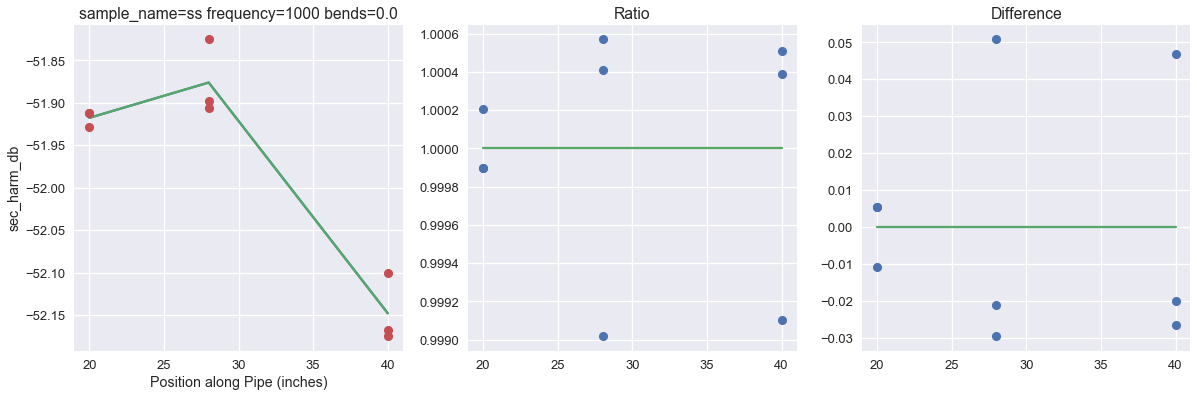

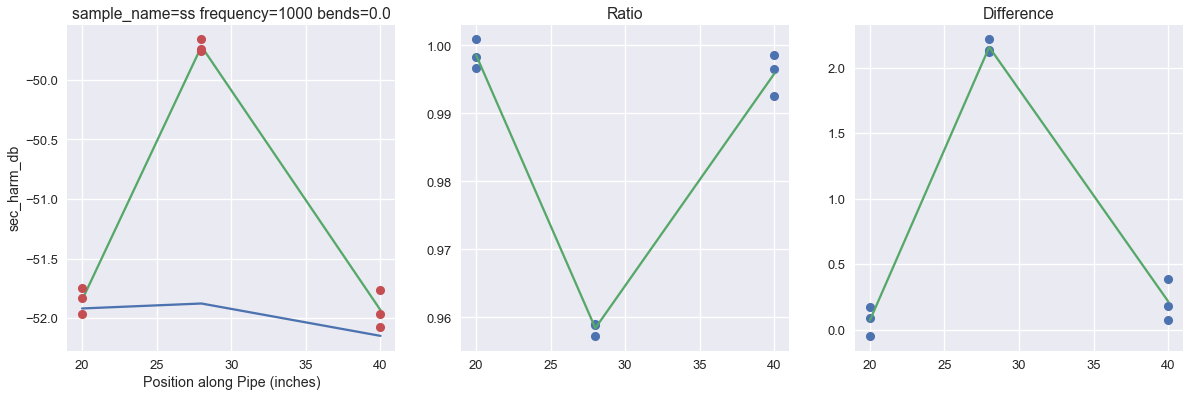

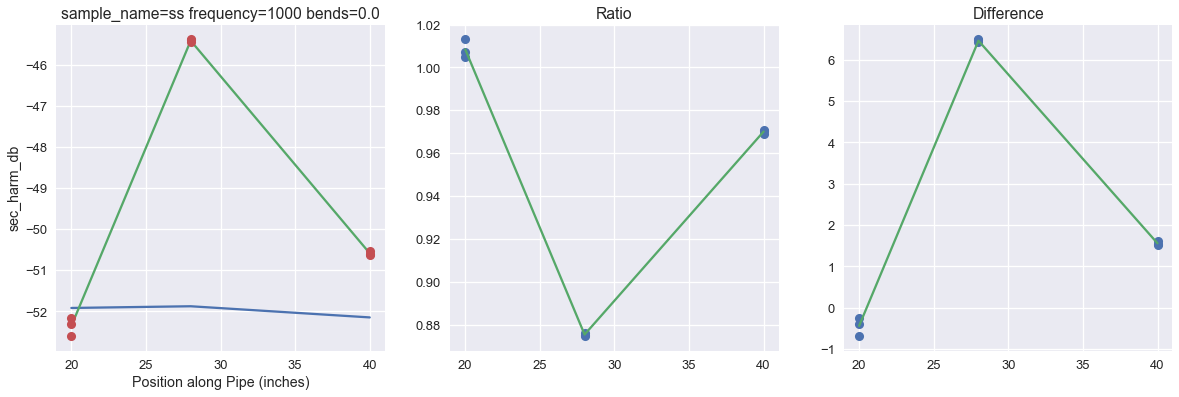

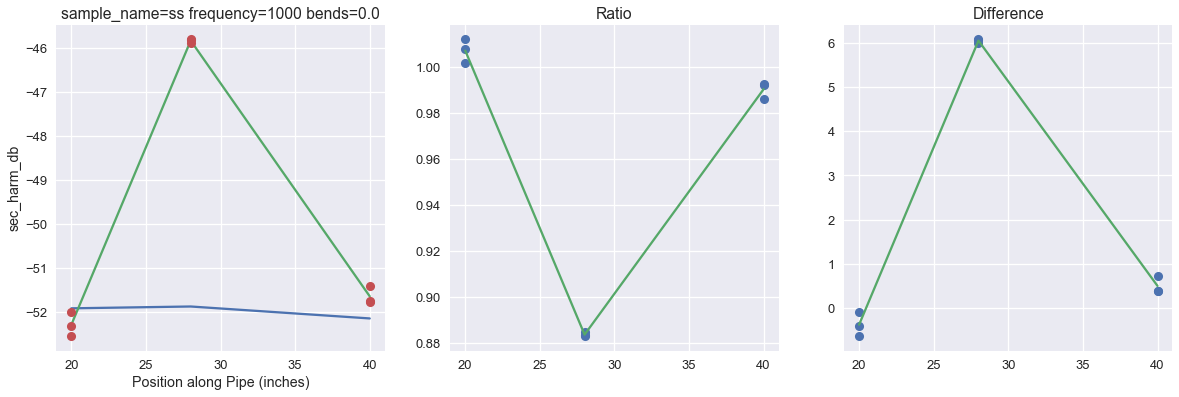

In [114]:
def plot_experiment(df, xparams, col_name):
    pl.rcParams['figure.figsize'] = (20, 6)
    sns.set_context('talk')

    # successively filter the frame to have only params listed in xparams
    key_cols = list(xparams.keys()) + ['pos']
    for k, v in xparams.items():
        if isinstance(v, tuple):
            overlay_col = k
            baseline_val = v[0]
        else:
            df = df[df[k] == v]
            
    # pull out the baseline_frames
    baseline_batch = df[df[overlay_col] == baseline_val]
    baseline_batch = baseline_batch.groupby(by=key_cols).mean().reset_index()
    
            
    # Run plotting overlays for all overlay groups
    for key, batch in df.groupby(by=overlay_col):
        mean_batch = batch.groupby(by=key_cols).mean().reset_index()
        
#         display(xparams, batch.head(2), baseline_batch.head(3), col_name)
        pl.figure()
        _plot_frame(xparams, batch, baseline_batch, mean_batch, col_name)
#         return
        
    
print(len(df_log))
print('sample', sorted(df_log['sample'].unique()))
print('freq', sorted(df_log.frequency.unique()))
print('bends', sorted(df_log.bends.unique()))        
    
    

xparams = dict(
    sample_name='ss',
    frequency=1000,
    bends=(0.,),
)
plot_experiment(df, xparams, 'sec_harm_db')
print(xparams)

In [102]:
def _plot_frame(xparams, df, df_baseline, df_mean,  col_name):
    title_val = ' '.join([f'{k}={v[0] if isinstance(v, tuple) else v}' for (k, v) in xparams.items()])
    baseline_col = f'{col_name}_b'
    mean_col = f'{col_name}_m'
    
    df = df[['pos', col_name]]
    dfb = df_baseline[['pos', col_name]]
    dfm = df_mean[['pos', col_name]]
    
    dfj = pd.merge(df, dfb, on='pos', suffixes=['', '_b']).dropna()
    dfj = pd.merge(dfj, dfm, on='pos', suffixes=['', '_m']).dropna()
    
    
    dfj.loc[:, 'delta'] = dfj[col_name] - dfj[baseline_col]
    dfj.loc[:, 'ratio'] = dfj[col_name] / dfj[baseline_col]
    dfj.loc[:, 'delta_m'] = dfj[mean_col] - dfj[baseline_col]
    dfj.loc[:, 'ratio_m'] = dfj[mean_col] / dfj[baseline_col]
    
    pl.subplot(131)
    pl.plot(dfj.pos, dfj[baseline_col])
    pl.plot(dfj.pos, dfj[mean_col])
    pl.plot(dfj.pos, dfj[col_name], 'o')
    pl.xlabel('Position along Pipe (inches)')
    pl.title(title_val)
    pl.ylabel(col_name)
    
    pl.subplot(132)
    pl.plot(dfj.pos, dfj.ratio, 'o')
    pl.plot(dfj.pos, dfj.ratio_m, '-')
    
    pl.title('Ratio')

    pl.subplot(133)
    pl.plot(dfj.pos, dfj.delta, 'o')
    pl.plot(dfj.pos, dfj.delta_m, '-')
    
    pl.title('Difference')
    
    


In [56]:
def _plot_frame(xparams, df, df_baseline, col_name):
    
    df = df[['pos', col_name]]
    dfb = df_baseline[['pos', col_name]]
    dfj = pd.merge(df, dfb, on='pos', suffixes=['', '_b']).dropna()
    dfj.loc[:, 'delta'] = dfj[col_name] - dfj[f'{col_name}_b']
    dfj.loc[:, 'ratio'] = dfj[col_name] / dfj[f'{col_name}_b']
    display(dfj.head(2))
    return
    
    
    
    title_val = ' '.join([f'{k}={v} ' for (k, v) in xparams.items() if not isinstance(v, tuple)])
    print(title_val)
    return
    pl.subplot(131)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label], '.-', label=pipe_label, )
    pl.plot(dfx.pos, dfx.virgin, '.-', label='Virgin', )
    pl.legend(loc='best')
    pl.xlabel(xlabel)
    if ylabel is not None:
        pl.title(title);
        
    pl.subplot(132)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label] / dfx.virgin, '.-', label=f'{pipe_label} ratio')
    pl.xlabel(xlabel)
    pl.legend(loc='best')
    pl.title(title)
    pl.subplot(133)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label] - dfx.virgin, '.-', label=f'{pipe_label} diff')
    pl.xlabel(xlabel)
    pl.title(title)
    pl.legend(loc='best')
 

In [21]:
# def get_col(df, col_name):
#     df = df.pivot(index='pos', columns='pipe_label', values=col_name)
#     df = df.reset_index(drop=False)
#     df.index.name = col_name
#     df.columns.name = None
#     return df

def get_col(df, col_name):
    df = df.set_index(['pos', 'life']).unstack('life')
    return df
    df = df.pivot(index='pos', columns='pipe_label', values=col_name)
    df = df.reset_index(drop=False)
    df.index.name = col_name
    df.columns.name = None
    return df

In [ ]:
def do_plot(df, field_name, pipe_labels, title=None, ylabel=None):
    xlabel = 'Position along Pipe (inches)'
    
    dfx = get_col(df, field_name)
    pl.rcParams['figure.figsize'] = (20, 6)
    sns.set_context('talk')
    
    pl.subplot(131)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label], '.-', label=pipe_label, )
    pl.plot(dfx.pos, dfx.virgin, '.-', label='Virgin', )
    pl.legend(loc='best')
    pl.xlabel(xlabel)
    if ylabel is not None:
        pl.title(title);
        
    pl.subplot(132)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label] / dfx.virgin, '.-', label=f'{pipe_label} ratio')
    pl.xlabel(xlabel)
    pl.legend(loc='best')
    pl.title(title)
    pl.subplot(133)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label] - dfx.virgin, '.-', label=f'{pipe_label} diff')
    pl.xlabel(xlabel)
    pl.title(title)
    pl.legend(loc='best')

pipe_labels = [
    'ss_50',
    'ss_80',
    'ss_100_a',
    'ss_100_b',
]


pl.figure()
do_plot(df, 'prim_sec_amp', pipe_labels, title='Primary-Secondary Coupling', ylabel='Mutual Inductance')

# pl.figure()
# do_plot(df, 'prim_rec_amp', pipe_labels, title='Primary-Receiver Coupling', ylabel='Mutual Inductance')
# pl.figure()
# do_plot(df, 'sec_harm_db', pipe_labels, title='3rd Harmonic Power', ylabel='dB')



In [ ]:
df.head()

In [ ]:
from daq.pico import CSV
from harmonic import Harmonic
from easier import shade
from scipy import signal

In [ ]:
file_name = './20180312/20180312-0005.csv'
df = CSV(file_name=file_name, max_sample_freq=1e9, **channel_mapper).df
# filter_cols = ['res_volt', 'sec_volt', 'rec_volt']
# for col in filter_cols:
#     # 8 pol filter at .01 of nyquist
#     b, a = signal.butter(8, 0.01)
#     df.loc[:, col] = signal.filtfilt(b, a, df[col].values, padlen=150)


harmonics = [1, 3,]
h_i_prim = Harmonic(harmonics=harmonics)
h_i_prim.fit(df.t, df.res_volt)
h_i_prim = h_i_prim.derivative()

h_v_sec = Harmonic(harmonics=harmonics)
h_v_sec.fit(df.t, df.sec_volt)

h_v_rec = Harmonic(harmonics=harmonics)
h_v_rec.fit(df.t, df.rec_volt)

# compute "impedence" objects
h_z_prim_sec = h_v_sec / h_i_prim
h_z_prim_rec = h_v_rec / h_i_prim
h_z_sec_rec = h_v_rec / h_v_sec



In [ ]:
%%opts RGB [width=800, height=350]
x, y = df.t, df.sec_volt
yf = h_v_sec.predict(df.t)

((
    shade(hv.Curve((x, y)), color='blue')
    *shade(hv.Curve((x, yf)), color='red')
) + (
    shade(hv.Curve((x, y - yf), vdims=['sss']), color='blue')
)).cols(1)


In [ ]:
%%opts RGB [width=800, height=350]
x, y = df.t, df.sec_volt
yf = h_v_sec.predict(df.t)

((
    shade(hv.Curve((x, y)), color='blue')
    *shade(hv.Curve((x, yf)), color='red')
) + (
    shade(hv.Curve((x, y - yf), vdims=['sss']), color='blue')
)).cols(1)


In [ ]:
%%opts RGB [width=800, height=350]
from scipy import signal
t, y = df.t.values, df.sec_volt.values

b, a = signal.butter(8, 0.01)
yf1 = signal.filtfilt(b, a, y, padlen=150)

kd = hv.Dimension('time', range=(0, .1))
vd = hv.Dimension('amp', range=(-6.5, 6.5))

(
shade(hv.Curve((t, y), kdims=[kd], vdims=[vd]))    
*shade(hv.Curve((t, yf1), kdims=[kd], vdims=[vd]), color='red')  
*shade(hv.Curve((t, yf2), kdims=[kd], vdims=[vd]), color='green')  
    
)


In [ ]:
.005 * round(.5 / (t[1] - t[0]))

In [ ]:
class SFFT:
    def _get_padded_length(self, initial_length, interp_exp=0):
        for nn in range(int(1e6)):
            padded_length = 2 ** nn
            if padded_length >= initial_length:
                break
        return padded_length * 2 ** interp_exp

    def fft(self, time, amplitude, interp_exp=3):
        # demean the signal
        amplitude = amplitude - np.mean(amplitude)

        # pad length to power of two with maybe some interpolation
        padded_length = self._get_padded_length(len(amplitude), interp_exp=interp_exp)

        # get the sample time
        dt = np.median(np.diff(time))

        # compute the fft
        z = np.fft.fft(amplitude, n=padded_length)

        # define a slice for postive frequencies
        ind = slice(0, int((len(z) / 4)))

        # get positive amplitudes
        amp_f = np.abs(z)[ind]

        # compute positive freqs
        f = np.fft.fftfreq(len(z), d=dt)[ind]
        return f, amp_f
   
f, amp = SFFT().fft(df.t, df.sec_volt - df.sec_volt.mean())

In [ ]:
%%opts Curve [width=800, height=350 logy=False, logx=False]
hv.Curve((f, amp))

In [ ]:
pl.loglog(f, amp)

In [ ]:
from astropy import units as u

In [ ]:
C = 80 * u.uF
(1. / (1j * 2 * np.pi * 50000 * u.Hz * C)).to(u.Ohm)

In [ ]:
f = 50 * u.kHz
w = 2 * np.pi * f
C = 10 * u.uF
X = 1. / (1j * w * C)
X.to(u.Ohm)

In [ ]:
# demean the signal
amplitude = amplitude - np.mean(amplitude)

# pad length to power of two with maybe some interpolation
padded_length = self._get_padded_length(len(amplitude), interp_exp=interp_exp)

# get the sample time
dt = np.median(np.diff(time))

# compute the fft
z = fft(amplitude, n=padded_length)

# define a slice for postive frequencies
ind = slice(0, int((len(z) / 2)))

# get positive amplitudes
amp_f = np.abs(z)[ind]

# compute positive freqs
f = np.fft.fftfreq(len(z), d=dt)[ind]

# return the max freq
return f[np.where(amp_f == np.max(amp_f))[0]][0]

In [ ]:
def get_data(df_log, data_dir, njobs=1, reload=False):
    results_file = os.path.join(data_dir, 'results.txt')
    if reload:
        df = None
        for (pipe_label, _, freq), batch in df_log.groupby(by=['sample', 'fatigue_life', 'frequency']):
            pipe_label = f'{pipe_label}pct_{freq:0.0f}hz'
            p = Pipe(pipe_label, batch, channel_mapper, n_jobs=njobs, harmonic=3)
            p.process()
            if df is None:
                df = p.df
            else:
                df = df.append(p.df, ignore_index=True)
        df.to_csv(results_file, index=False)
        
    df = pd.read_csv(results_file)
    df = df.rename(columns={'pipe': 'pipe_label'})
    dfj = pd.merge(df, df_log, on=['pipe_label', 'pos'], how='left')
    print('-'*80)
    display(df_log.tail())
    print('-'*80)
    display(df.tail())
    print('-'*80)
    display(dfj.tail())
    
    fields = [
        'fatigue_life',
        'frequency'
    ]
    
    for field in fields:
        df.insert(1, field, dfj[field])
    
    return df

with ezr.Timer('get_data'):
    df = get_data(df_log, data_dir, njobs=2, reload=True, max_files=3)
df = df[df.pipe_label.str.startswith('ss')]
# df.head(3)